# Bayesian Data Analysis in Python

Bayesian data analysis is an increasingly popular method of statistical inference, used to determine conditional probability without having to rely on fixed constants such as confidence levels or p-values. In this course, we’ll learn how Bayesian data analysis works, how it differs from the classical approach, and why it’s an indispensable part of our data science toolbox. We’ll get to grips with A/B testing, decision analysis, and linear regression modeling using a Bayesian approach as we analyze real-world advertising, sales, and bike rental data. Finally, we’ll get hands-on with the PyMC3 library, which will make it easier for us to design, fit, and interpret Bayesian models.

## 1. The Bayesian way

Our first steps in the Bayesian world. In this chapter, we’ll be introduced to the basic concepts of probability and statistical distributions, as well as to the famous Bayes' Theorem, the cornerstone of Bayesian methods. Finally, we’ll build our first Bayesian model to draw conclusions from randomized coin tosses.

<img src="fig/this_is_the_way.jpg" width=400  />

What is Bayes? Bayesian inference means updating one's belief about something as the new informationbecomes available. It is quite different from the classical approach, see the table below:

<img src="fig/bayes_vs_class.png" width=400  />

The main advantages of the Bayesian approach over Frequentist (classical) approach:
- Natural handling of uncertainty (because parameters have distributions!).
- Possibility to include expert opinion or domain knowledge in the model (because probability means the degree of belief!).
- No need to rely on fixed constants such as p-values.
- Statistically correct even with little data.
- Often coincides with frequentist results, but offers more flexibility to build custom models.

Based on the description above, we have the general idea of what the Bayesian approach is all about. Among other things, we know that for a Bayesian, parameters of statistical models are random variables which can be described by probability distributions.

#### 1.1 Probability and Bayes' Theorem
SCENARIO: _You have a regular deck of 52 well-shuffled playing cards. The deck consists of 4 suits, and there are 13 cards in each suite: ranks 2 through 10, a jack, a queen, a king, and an ace. This means that in the whole deck of 52, there are four of each distinct rank: four aces, four kings, four tens, four fives, etc._

Since there are 52 distinct cards, the probability of drawing any one particular card is 1/52. The goal is to calculate the probabilities of drawing some specific combinations of cards, as described in the instructions/comments.

In [1]:
# Import packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [7]:
# Calculate probability of drawing a king or queen
p_king_or_queen = 4*(1/52) + 4*(1/52) # four kings or queens
print("The probability of  drawing a king or queen is {0:.2f}.".format(p_king_or_queen))

# Calculate probability of drawing <= 5
p_five_or_less = 4*4*(1/52) # card 2, 3, 4, 5 time 4 each
print("The probability of  drawing <= 5 is {0:.2f}.".format(p_five_or_less))

# Calculate probability of drawing four aces
p_all_four_aces = 4*(1/52)*3*(1/51)*2*(1/50)*1*(1/49) # drawing without replacement
print("The probability of drawing all four aces in row is {0:.8f}.".format(p_all_four_aces))

The probability of  drawing a king or queen is 0.15.
The probability of  drawing <= 5 is 0.31.
The probability of drawing all four aces in row is 0.00000369.


Probably well done! The chance of drawing four aces straight is 0.00037%, so don't hope for it too much! Now that we're an expert in manipulating probabilities, let's take a look at Bayes' Theorem and how to use it to detect spam messages.

SCENARIO: _While browsing your inbox, you have figured out that quite a few of the emails you would rather not waste your time on reading contain exclamatory statements, such as "BUY NOW!!!". You start thinking that the presence of three exclamation marks next to each other might be a good spam predictor! Hence you've prepared a DataFrame called `emails` with two variables: `spam`, whether the email was spam, and `contains_3_exlc`, whether it contains the string "!!!"._

__NOTE:__ The `emails` dataset is not available online and it is built manually for this exercise.

Our job is to calculate the probability of the email being spam given that it contains three exclamation marks. Let's tackle it step by step! Here is Bayes' formula for our reference:

$$ P(A | B) = \frac{ P(B | A) \times P(A)}{ P(B) } $$

In [9]:
# load and preview the data
emails = pd.read_csv('data/emails.csv', index_col=[0])
emails.head()

,spam,contains_3_excl
0,False,False
1,False,False
2,True,False
3,False,False
4,False,False


In [14]:
# Calculate and print the unconditional probability of spam
p_spam = emails['spam'].mean()
print("The unconditional probability of spam is {0:.2f}.".format(p_spam))

# Calculate and print the unconditional probability of "!!!"
p_3_excl = emails["contains_3_excl"].mean()
print("The unconditional probability of \"!!!\" is {0:.2f}.".format(p_3_excl))

# Calculate and print the probability of "!!!" given spam
p_3_excl_given_spam = emails.loc[emails["spam"]]["contains_3_excl"].mean()
print("The unconditional probability of \"!!!\" given spam is {0:.2f}.".format(p_3_excl_given_spam))

# Calculate and print the probability of spam given "!!!"
p_spam_given_3_excl = p_3_excl_given_spam * p_spam / p_3_excl
print("The unconditional probability of spam given \"!!!\" is {0:.2f}.".format(p_spam_given_3_excl))

The unconditional probability of spam is 0.24.
The unconditional probability of "!!!" is 0.17.
The unconditional probability of "!!!" given spam is 0.60.
The unconditional probability of spam given "!!!" is 0.86.


If an email contains the '!!!', you can be 85% sure it is spam! Next, let's use Bayes' Theorem in practice once again, but this time without the data neatly gathered in a DataFrame!

SCENARIO: _A doctor suspects a disease in their patient, so they run a medical test. The test's manufacturer claims that 99% of sick patients test positive, while the doctor has observed that the test comes back positive in 2% of all cases. The suspected disease is quite rare: only 1 in 1000 people suffer from it._

The test result came back positive. __What is the probability that the patient is indeed sick?__ We can use Bayes' Theorem to answer this question. Here is what you should calculate:

$$ P(\text{sick} | \text{positive}) = \frac{ P(\text{positive} | \text{sick}) \times P(\text{sick})}{ P(\text{positive}) } $$

In [15]:
print(0.99 * (1/1000) / 0.02)

0.049499999999999995


Not very intuitive, is it? Even though the test is great at discovering the disease and raises false alarms rather seldom, a positive result means only a 5% probability that the patient is sick!

#### 1.2 Tasting the Bayes

In this part we will use a custom `get_heads_prob()` function that estimates the probability of success of a binomial distribution. In this exercise, we will use it and verify whether it does its job well in a coin-flipping experiment.

Watch out for the confusion: there are two different probability distributions involved! One is the binomial, which we use to model the coin-flipping. It's a discrete distribution with two possible values (heads or tails) parametrized with the probability of success (tossing heads). The Bayesian estimate of this parameter is another, continuous probability distribution. We don't know what kind of distribution it is, but we can estimate it with `get_heads_prob()` and visualize it.

In [16]:
def get_heads_prob(tosses):
    """
    Estimates the probability of success of a binomial distribution.

    Parameters
    ----------
    tosses : array
        List of coin-flipping trials with two possible values 0s and 1s.

    Returns
    -------
    probability distribution: array
        continuous probability of success (tossing heads).

    See Also
    --------
    https://campus.datacamp.com/courses/bayesian-data-analysis-in-python/the-bayesian-way?ex=9.
    """
    
    num_heads = np.sum(tosses)
    return np.random.beta(num_heads + 1, 
                          len(tosses) - num_heads + 1, 
                          1000)

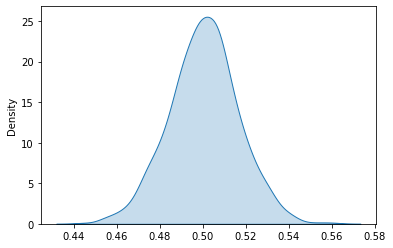

In [17]:
# Generate 1000 coin tosses
tosses = np.random.binomial(1, 0.5, size=1000)

# Estimate the heads probability
heads_prob = get_heads_prob(tosses)

# Plot the distribution of heads probability
sns.kdeplot(heads_prob, shade=True, label="heads probabilty")
plt.show()

The density plot peaks around 50%, indicating that the model has estimated the heads probability well. Now that you're familiar with `get_heads_prob()`, let's explore it in more detail in the next exercise!

SCENARIO: _Imagine you are a frequentist (just for a day), and you've been tasked with estimating the probability of tossing heads with a (possibly biased) coin, but without observing any tosses. What would you say? It's impossible, there is no data! Then, you are allowed to flip the coin once. You get tails. What do you say now? Well, if that's all your data, you'd say the heads probability is 0%._

You can probably feel deep inside that these answers are not the best ones. But what would be better? What would a Bayesian say? Let's find out!

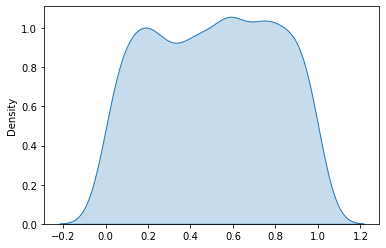

In [18]:
# Estimate and plot heads probability based on no data
heads_prob_nodata = get_heads_prob([]) # heads probability based on an empty list
sns.kdeplot(heads_prob_nodata, shade=True, label="no data")
plt.show()

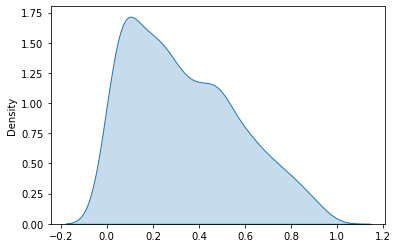

In [19]:
# Estimate and plot heads probability based on a single tails
heads_prob_onetails = get_heads_prob([0]) # a single tail (a list with a single 0)
sns.kdeplot(heads_prob_onetails, shade=True, label="single tails")
plt.show()

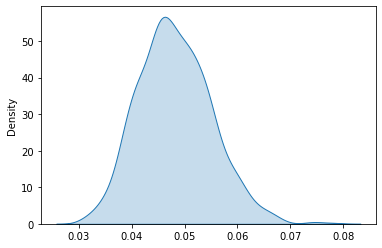

In [20]:
# Estimate and plot heads probability based on 1000 tosses with a biased coin which comes up heads only 5% of all times
biased_tosses = np.random.binomial(1, 0.05, size=1000)
heads_prob_biased = get_heads_prob(biased_tosses)
sns.kdeplot(heads_prob_biased, shade=True, label="biased coin")
plt.show()

That's interesting! With no data, each possible value of the heads probabilty is equally likely! That's the Bayesian way of saying 'we don't know'. Having seen a single tails, the model suspects that tails is more likely than heads, but since there is so little data, it is not very sure about it, so other values are possible, too. Having seen 1000 tosses, 5% of them heads, the model is certain: the heads probability is around 5%. __We have just witnessed the Bayesian approach at its core: as more data come in, we update our belief about the parameter, and with more data we become more certain about our estimate!__

In the last two exercises, we have examined the `get_heads_prob()` function to discover how the model estimates the probability of tossing heads and how it updates its estimate as more data comes in.

Now, let's get down to some serious stuff:

SCENARIO: _Would you like to play coin flipping against your friend? She is willing to play, as long as you use her special lucky coin. The tosses variable contains a list of 1000 results of tossing her coin. Will you play?_

In [22]:
tosses = [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 
          1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 
          1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 
          1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 
          1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 
          0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 
          1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 
          1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 
          1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 
          0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 
          1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 
          0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 
          0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 
          1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 
          1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 
          1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 
          1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 
          1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 
          1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 
          1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 
          1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 
          1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]

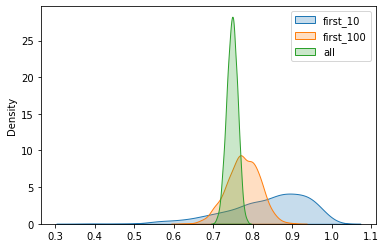

In [24]:
# Assign first 10 and 100 tosses to separate variables
tosses_first_10 = tosses[:10]
tosses_first_100 = tosses[:100]

# Get head probabilities for first 10, first 100, and all tossses
heads_prob_first_10 = get_heads_prob(tosses_first_10)
heads_prob_first_100 = get_heads_prob(tosses_first_100)
heads_prob_all = get_heads_prob(tosses)

# Plot density of head probability for each subset of tosses
sns.kdeplot(heads_prob_first_10, shade=True, label="first_10")
sns.kdeplot(heads_prob_first_100, shade=True, label="first_100")
sns.kdeplot(heads_prob_all, shade=True, label="all")
plt.legend()
plt.show()

The coin seems to be biased, it is more likely to come up heads than tails. You're right refusing to play with this particular coin. The chance it comes up heads is 75% to be precise, and the model got it right - having seen all 1000 tosses, the estimated distribution peaks at 0.75. With smaller data samples, however, the model didn't have the chance to learn the true value. You can see how uncertain it is from the width of the corresponding distributions. Are you curious how this model works, and how it updates its estimates with more data? Head off to Chapter 2 to find out!